# Baseline Convolutional Neural Networks on CIFAR-10

A convolutional neural network is a type of deep learning model designed to process data with a grid-like topology, such as images. It is particularly effective for image recognition tasks due to its ability to automatically and adaptively learn spatial hierarchies of features from input data.

Each convolutional layer works by applying a number of filters over a sliding image on the input and performing element-wise multiplication, followed by a summation operation. This process extracts local features from the input data, which are then passed through an activation function to introduce non-linearity. Each filter used in the layer produces another output channel. The output of the convolutional layer is then passed to the next layer, where the process is repeated.


Let:
* $X$ be the input image of size $H \times W \times C_{in}$
* $W$ be the width of the filter
* $K_H$ and $K_W$ be the height and width of the filter kernel
* $C_{out}$ be the number of output channels
* $C_{in}$ be the number of input channels

The the output of a single convolutional layer is computed as:
$$
Y_{k, i, j} = b_k + \sum_{c=0}^{C_{in}-1} \sum_{m=0}^{K_H-1} \sum_{n=0}^{K_W-1} W_{k, c, m, n} \cdot X_{c, i+m, j+n}
$$

 ## Environment Setup and Data Preparation

The preparation of the dataset for CNNs is identical to its preparation for FFNNs as in the previous notebook, which ensures consistency in data handling.

However, the preprocessing is changed in that we define a custom transformation that normalizes the data. This step helps the CNN converge faster, as it turns the values from positive values in the range [0,1] to [-1,1]. This is done using the transform.Normalize() method which requires the mean and std of each channel in the dataset (RGB in this case).

To find the mean and std of each channel in the dataset, we first load the raw pixel data and scale it to the range [0,1]. Then, we calculate the mean and std for each channel across all images. These values are used to normalize the data during training.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import copy
import utils
import pandas as pd

Calculate dataset statistics for normalization

In [5]:
raw_train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
raw_pixels = raw_train_data.data
pixels_scaled = raw_pixels / 255.0 # scale to [0,1] range
dataset_means = pixels_scaled.mean(axis=(0, 1, 2))
dataset_stds = pixels_scaled.std(axis=(0, 1, 2))
print(dataset_means, dataset_stds)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_means, dataset_stds)
])

[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [6]:
# Download training and test sets and normalize
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_data = torch.utils.data.Subset(full_test_data, indices=list(range(5000)))
test_data = torch.utils.data.Subset(full_test_data, indices=list(range(5000, 10000)))

# Create DataLoaders
batch_size = 64
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

### Model Definition

Here we define a Convolutional Neural Network (CNN) for image classification on the CIFAR-10 dataset. The CNN architecture consists of convolutional layers followed by max pooling layers, and ends with fully connected layers for classification.

Convolutional layers are layers that learn filters to extract features from the input image. The operation they perform is a matrix multiplication of a moving window of the input image with a filter matrix.

Max pooling layers reduce the spatial size of the feature maps by taking the maximum value within each pooling region. In practice they are a convolutional layer with a window size of 2x2 and stride of 2: the stride parameter specifies the number of pixels to skip between two pooling regions and thus cuts the feature map size in half.

* The first convolutional layer takes the input image and produces a 16 feature map of size 32x32.
* Max pooling reduces the size of the feature maps to 16x16.
* The second convolutional layer produces a 32 feature map of size 16x16.
* Max pooling reduces the size of the feature maps to 8x8.
* The fully connected layers classify the 8x8x32 images into 10 classes.

This is an initial architecture that aims to extract a relatively large amount of features from the input image and then classify them into 10 classes.

In [7]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Image input is a 3-channel RGB image of size 32x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Image is now 32x32x16, after 16 3x3 kernels were applied
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Image is now 16x16x16, after 2x2 max pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Image is now 16x16x32, and will then be pooled again to 8x8x32 and then classified

        # Classifier
        self.fc1 = nn.Linear(8*8*32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv1(x)))
        # Conv2 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape the image into a flat vector for the fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # No softmax here, CrossEntropyLoss handles it
        return x

We can evaluate how more efficient this model is by looking at the number of weights in it.

To recall, the optimal FFNN that was found in the previous notebook had 3072 inputs, 10 outputs and the following hidden layers: [1024, 512, 256]. This means it had $3072 \times 1024 + 1024 \times 512 + 512 \times 256 + 256 \times 10 = 3,803,648$ parameters.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_cnn = BaselineCNN().to(device)
total_params = sum(p.numel() for p in baseline_cnn.parameters())
print(f"Total parameters in BaselineCNN: {total_params:,}")

Total parameters in BaselineCNN: 268,650


Our Convolutional Neural Network is 14 times smaller!

### Training

The convenient thing about PyTorch is that it abstracts the internal working of a model, which allows things like training and evaluation functions to be reused. Therefore the relevant functions used in the previous notebook can be used as-is here and are simply copied.

In [9]:
def evaluate(model, testloader, criterion, device):
    model.eval()  # Set to evaluation mode (turns off Dropout/BatchNorm)
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No gradient calculation saved (saves memory)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    loss = test_loss / len(testloader)
    acc = 100. * correct / len(testloader.dataset)
    return loss, acc

In [10]:
def train_CNN(model, trainloader, valloader, criterion, optimizer, device, epochs=5,
               console=False, early_stopping=False, patience=3):
    model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    best_val_loss = float('inf') # For early stopping
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improvement_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        epoch_val_loss, epoch_val_acc = evaluate(model, valloader, criterion, device)

        # Save to history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        if console:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")

        if early_stopping:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                # Save the best model weights
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improvement_counter = 0 # Reset counter
            else:
                no_improvement_counter += 1
                if console: print(f"  EarlyStopping counter: {no_improvement_counter} out of {patience}")

                if no_improvement_counter >= patience:
                    if console: print("Early stopping triggered! Restoring best weights...")
                    model.load_state_dict(best_model_wts) # Restore best model
                    break

    if console: print("Finished Training")
    return history

Since we have already established in the previous notebook why Adam is the superior optimizer over standard SGD (which is particularly true for CNNs) we will use it here as well.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_cnn.parameters(), lr=0.001)
train_results = train_CNN(baseline_cnn, trainloader, valloader, criterion, optimizer, device, epochs=10, console=True)

Epoch 1/10 | Train Loss: 1.3784 | Train Acc: 50.72% | Val Loss: 1.1395 | Val Acc: 60.06%
Epoch 2/10 | Train Loss: 1.0347 | Train Acc: 63.45% | Val Loss: 0.9782 | Val Acc: 65.64%
Epoch 3/10 | Train Loss: 0.8947 | Train Acc: 68.62% | Val Loss: 0.9253 | Val Acc: 67.54%
Epoch 4/10 | Train Loss: 0.7952 | Train Acc: 72.04% | Val Loss: 0.8799 | Val Acc: 69.86%
Epoch 5/10 | Train Loss: 0.7105 | Train Acc: 75.08% | Val Loss: 0.8687 | Val Acc: 70.54%
Epoch 6/10 | Train Loss: 0.6365 | Train Acc: 77.61% | Val Loss: 0.9149 | Val Acc: 68.74%
Epoch 7/10 | Train Loss: 0.5653 | Train Acc: 80.01% | Val Loss: 0.8808 | Val Acc: 71.22%
Epoch 8/10 | Train Loss: 0.5034 | Train Acc: 82.20% | Val Loss: 0.9859 | Val Acc: 69.46%
Epoch 9/10 | Train Loss: 0.4453 | Train Acc: 84.30% | Val Loss: 1.0050 | Val Acc: 69.62%
Epoch 10/10 | Train Loss: 0.3866 | Train Acc: 86.37% | Val Loss: 1.0799 | Val Acc: 69.18%
Finished Training


### Post-Training Evaluation

Just like with the FFNN, we can evaluate the CNN based on its accuracy and loss curves, and we can get a final evaluation based on the test set.

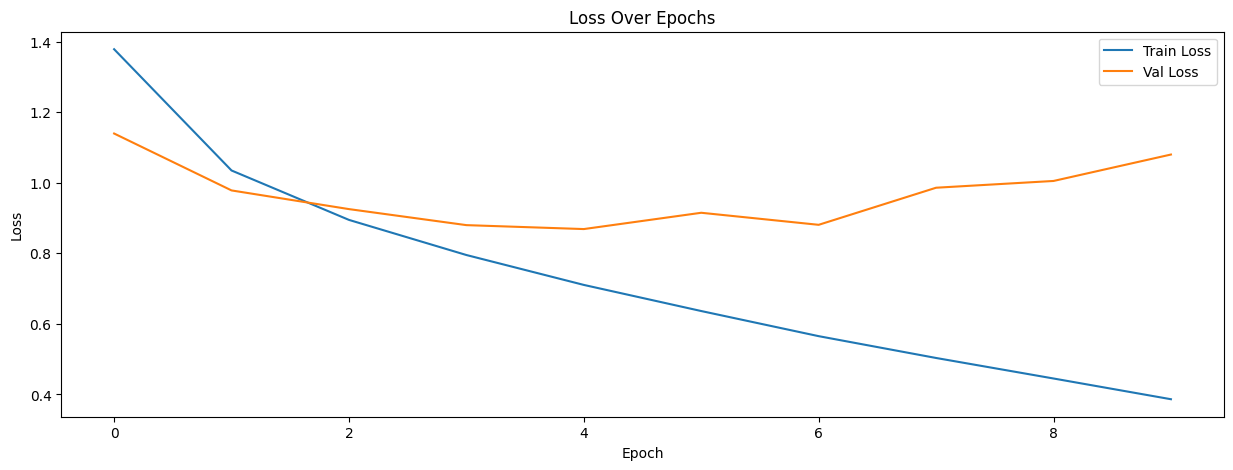

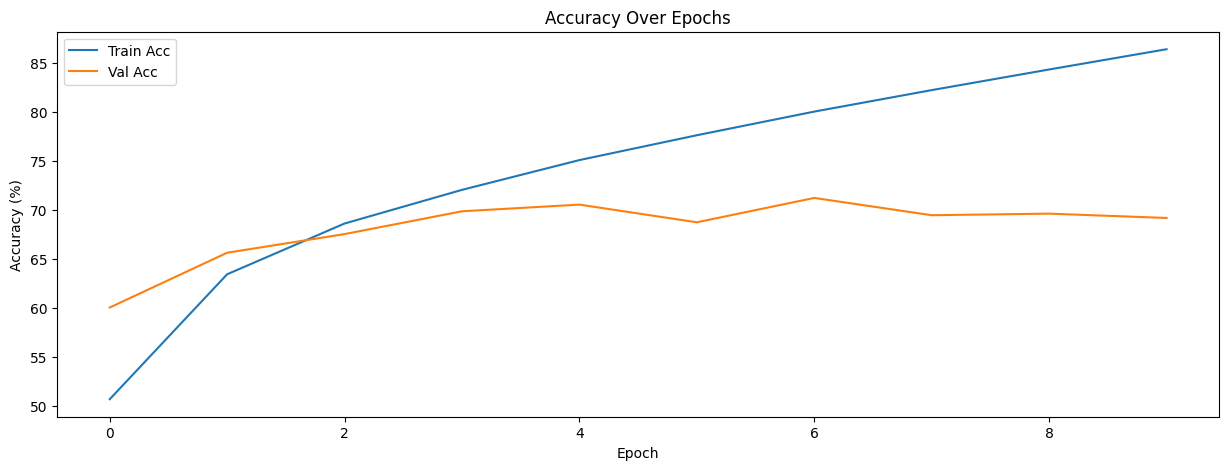

Test Loss: 1.0849, Test Acc: 68.54%


In [12]:
utils.plot_loss(train_results['train_loss'], train_results['val_loss'])
utils.plot_acc(train_results['train_acc'], train_results['val_acc'])
result = evaluate(baseline_cnn, testloader, criterion, device)
print(f"Test Loss: {result[0]:.4f}, Test Acc: {result[1]:.2f}%")

First of all, this result is already significantly better than anything we've seen in the previous notebook, as expected. 68.5% accuracy is a significant improvement over the 45% accuracy we achieved with the FFNN.

However, an issue of overfitting is clear. The training loss continues to decrease, while the validation loss remains stagnant and starts to increase after a certain point. There is a gap of 15% between the training and validation accuracies, which indicates high Variance: the model is overfitting to the training subset.

This is a common issue with CNNs and can be mitigated by using techniques that are examined in the next notebook.

But first, let's examine the model architecture, and see if performance can be improved by changing the current configuration.

## Model Architecture Exploration

Three different approaches are tested here to assess the effectiveness of enlarging the model:
1. **Depth:** The model is enlarged by adding more convolutional layers. This makes it into a 'Deep CNN', which is capable of detecting more complex patterns in the images.
2. **Width:** The model is enlarged by adding more channels to each convolutional layer. This makes it into a 'Wide CNN', which is capable of learning a larger variety of features from the images.
3. **Denseness:** The model is enlarged by adding more fully connected layers at its end. This makes it into a 'Dense CNN', which is capable of learning more complex relationships between features and make better final predictions.

The effectiveness of each approach is highly dependent on the dataset. We can hypothesize that for a dataset of small images with few classes like CIFAR-10, the depth of the model is more important than its width. This is because CIFAR-10 has a relatively small number of classes and images. The model needs to be able to detect complex patterns in the images to achieve high accuracy, rather than pick up a larger variety of patterns. We test this hypothesis by evaluating models that apply the three ideas above.

In addition, this time we will use the early stopping mechanism to prevent overfitting. It is configured in the training loop to save the parameters that resulted in the lowest validation loss during training, so that the best result is never lost. The patience hyperparameter defines how many epochs without improvement are tolerated before training is stopped, and it is set to 3 by default.

### Definitions

In [13]:
# For the deep CNN another convolutional layer is added for each previous such layer
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 32x32x3 image in -> 16x16x16 out
        self.conv1a = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2: 16x16x16 in -> 8x8x32 out
        self.conv2a = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # Pool

        # Classifier
        self.fc1 = nn.Linear(8*8*32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool(F.relu(self.conv2b(F.relu(self.conv2a(x)))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
# For the wide CNN the number of channels in each convolutional layer is increased by a factor of 2
class WideCNN(nn.Module):
    def __init__(self):
        super(WideCNN, self).__init__()
        # Block 1: 32x32x3 image in -> 16x16x32 out
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2: 16x16x32 image in -> 8x8x64 out
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Classifier
        self.fc1 = nn.Linear(8*8*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
# For the dense CNN the classifier is enlarged
class DenseCNN(nn.Module):
    def __init__(self):
        super(DenseCNN, self).__init__()
        # Block 1: 32x32x3 image in -> 16x16x16 out
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2: 16x16x16 image in -> 8x8x32 out
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Classifier
        self.fc1 = nn.Linear(8*8*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training

In [16]:
models = {
    'deep': DeepCNN().to(device),
    'wide': WideCNN().to(device),
    'dense': DenseCNN().to(device)
}

results_data = []
histories = dict()

# training for each model
for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = train_CNN(model, trainloader, valloader, criterion, optimizer, device,
                        epochs=10, early_stopping=True)

    final_train = history['train_acc'][-1]
    final_val = history['val_acc'][-1]
    results_data.append({
        'Model': name,
        'Train Acc': final_train,
        'Val Acc': final_val,
        'Gap': final_train - final_val
    })
    histories[name] = history

    print(f"{name:<10} | Train Acc: {final_train:.2f}% | Val Acc: {final_val:.2f}%")

deep       | Train Acc: 81.97% | Val Acc: 72.68%
wide       | Train Acc: 89.07% | Val Acc: 73.06%
dense      | Train Acc: 84.84% | Val Acc: 71.12%


### Results

,Model,Train Acc,Val Acc,Gap
0,deep,81.970,72.68,9.290
1,wide,89.074,73.06,16.014
2,dense,84.836,71.12,13.716


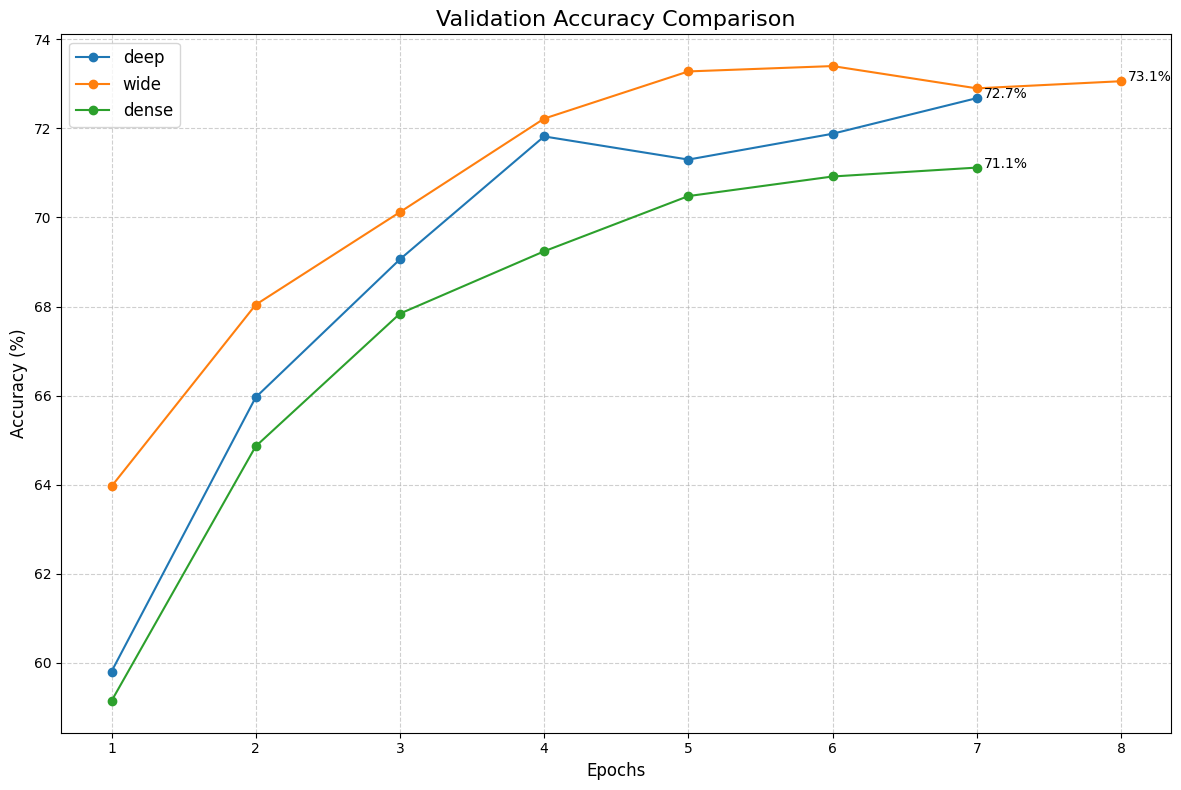

In [17]:
df_results = pd.DataFrame(results_data)
display(df_results)
utils.plot_validation_curves(histories)

It seems like the attempt to enlarge the model was ineffective and our hypothesis was false. Both the deep CNN and wide CNN capped at ~73% accuracy on the validation subset.

The deep CNN had the lowest gap between training and validation accuracy, significantly lower than the wide and dense CNNs. This indicates that the deep CNN is the one that is least likely to overfit, and the accuracy between it and the wide CNN is almost identical.

The dense CNN had worse performance and cut off earlier, indicating that it started overfitting earlier than the other two models, so enlarging the classifier only 'confused' the model.

It is worth examining the training curves of the deep CNN to understand it further:

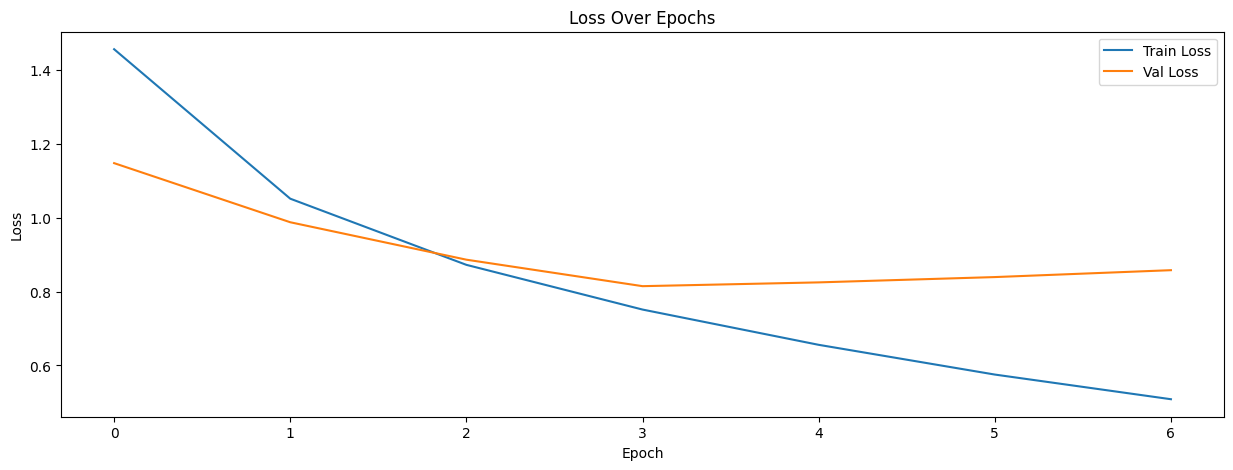

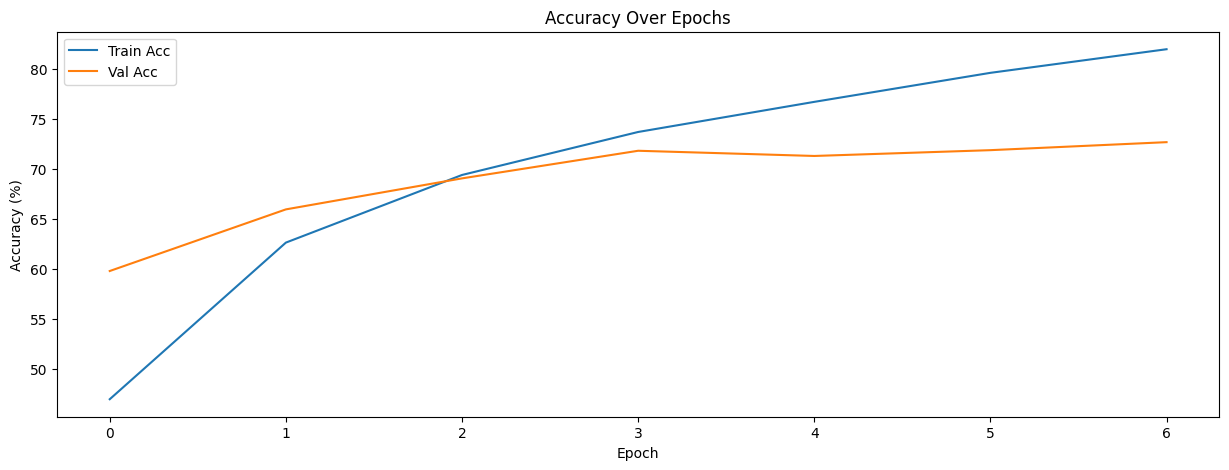

In [18]:
deep_results = histories['deep']
utils.plot_loss(deep_results['train_loss'], deep_results['val_loss'])
utils.plot_acc(deep_results['train_acc'], deep_results['val_acc'])

## Conclusions

When considering how the test accuracy continues to rise steadily over 80%, while the gap between training and validation accuracies widens, we can confidently say that the sole problem that the model is facing is overfitting. This problem is not caused by the model architecture, but by the fact that the model is 'too complex' for the current dataset.

To improve the model's performance we should consider other methods such as regularization techniques and data augmentation, which are examined in the next notebook.